# Bayesian Data Analysis 2019 - Data Analysis Project Report
Anonymous & Anonymous

## Analysis problem

The aim of this project is to analyse variation from month to month in public transportation. The variations from rush hours to late night are obvious to all of us using public transport. The decision makers are not necessarily analysing these changes between different months, even though it could prove valuable for example, in the maintenance, training and testing of equipment or operators. Therefore we want to look at the monthly variation from multiple years of data.

## Loaded packages

Below are the loaded packages that are used in the project. Remember to make sure that all the packages are installed into the system (for example, pystan).

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pystan
import datetime
import arviz as az
import seaborn as sns

# Description of data

The data set used is provided by UCI Machine Learning Repository.

The data set is called "Metro Interstate Traffic Volume Data Set", and it is described by the provider as follows: "Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume."

Below we load the data from our csv file. This file is accessible at https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume 

The part of the data we are the most interested in are the date_time and traffic_volume. From date_time we can easily capture the months and hours of data and from traffic volume, we get the number of passengers passing the specific station starting the mentioned hour. We are going to analyse the working days in order to avoid biases in the distributions and to focus on the business side of operating the transportation.

In [2]:
# load data

df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


Let's first look at the data in traffic volume. Below, we can see a histogram of passengers each hour. There are clearly a lot of really slow hours. Then, around 3000 and 4500 there are a couple of spikes. These spikes could be rush hours, last trains going through the station or similar, but we are not sure at this point. There do not seem to be clear anomalies, since the data is well spread out and the scale seems to fit automatically quite well, i.e. there are no singular values of 10000 or more.

Text(0.5, 1.0, 'Traffic volume')

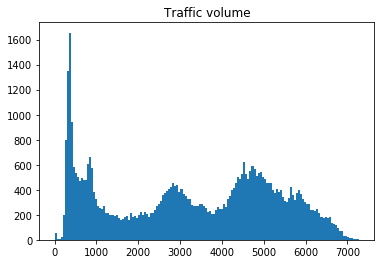

In [3]:
plt.hist(df['traffic_volume'], bins=150)
plt.title("Traffic volume")

Next, we will edit our data in order to gain better access into the hourly and monthly attributes.

In [4]:
# convert date_time-field into datetime format & add index
df_with_dates = df
df_with_dates['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df_with_dates = df_with_dates.set_index('date_time')
df_with_dates['weekday'] = df_with_dates.index.dayofweek
df_with_dates['month'] = df_with_dates.index.month
df_with_dates.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,weekday,month
date_time,,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,1,10
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,1,10
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,1,10
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,1,10
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,1,10


Text(0.5, 1.0, 'Traffic at 12:00')

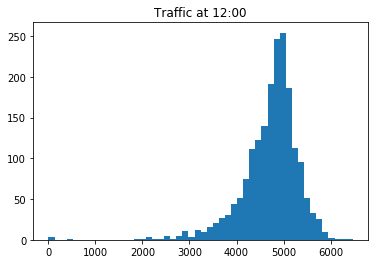

In [5]:
def traffic_at_time(time, dataframe):
    return dataframe.at_time('{}:00'.format(time))['traffic_volume']

# inefficient, but makes testing easier
traffic_by_time = [traffic_at_time(time, df_with_dates) for time in range(24)]

# make all sublists same size
def trim(arr):
    min_n = min([len(arr[n]) for n in range(len(arr))])
    return [arr[n][:min_n] for n in range(len(arr))]

traffic_by_time = trim(traffic_by_time)

# e.g. traffic volume at 12

plt.hist(traffic_by_time[12], bins=50)
plt.title("Traffic at 12:00")

Below, we have created an easily accessible dataframe on the traffic volumes of a certain month. The histogram below is at 8 o'clock in the weekday mornings in January. 

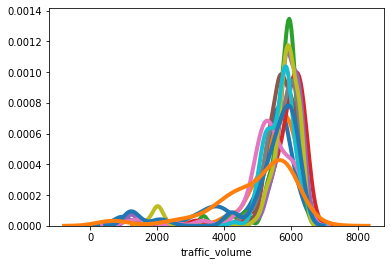

In [6]:
# holds traffic during weekdays at 8
traffic_by_month = [traffic_at_time(8, df_with_dates[(df_with_dates['month'] == month) & (df_with_dates['weekday'] < 5)]) 
                    for month in range(1,13)]

traffic_by_month = trim(traffic_by_month)
# traffic in january during weekdays at 8

[sns.distplot(traffic_by_month[i], hist=False, kde=True, 
             bins=int(180/5),
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}) for i in range(12)];

### Further analysis on data

In this part we have further analysed the extra data in the dataset. We also discuss some outliers and missing data. These **insights might help us form our distributions later on in the project and analyse the results**. Thus, we see it fit to look at the data even though it is not used. Feel free to skip this part.

In [7]:
#df.describe()

There are many labelled data columns in our data. Below we can see the holiday, weather main and weather description labels.

In [8]:
#df['holiday'].value_counts()

In [9]:
#df['weather_main'].value_counts()

In [10]:
#df['weather_description'].value_counts()

From the temperature data we can see that there are clear outliers. The x-axel is scaled from 0 to 300 even though there are barely any values below 250. When we dig deeper below the 250 values, we can see there are a couple of really low values. 

In [11]:
#plt.hist(df['temp'], bins=50)
#plt.title("Temperature")

In [12]:
#df_low_temp = df[df['temp'] < 250]
#plt.hist(df_low_temp['temp'], bins=50)
#plt.title("Low temperatures")

In [13]:
#df[df['temp'] == 0]

When we look at these zero Kelvin temperatures, we can see that the observations seem otherwise correct. The sky is clear, there is no rain or snow, and there are some small amounts of traffic during that time. Thus, we suggest that these datapoints only lack the temperature data and can still be used. We would fix the points by taking the average temperature during similar times (Jan-Feb nights).

Next off is the rain. We can see again that there are some outliers. When we take the description of our data, we see there is a datapoint with around 9831 mm of rain. Otherwise, the data seems reasonable. There are some 50mm rain points, but this is still realistic within one hour of really heavy rain. We would set the 9831mm datapoint to an average of our very heavy rain weather descriptions.

In [14]:
#plt.hist(df['rain_1h'], bins=50)
#plt.title("Rain")

In [15]:
#df[df['weather_description'] == 'very heavy rain']

In [16]:
#df_rain = df[df['rain_1h'] < 9831]
#plt.hist(df_rain['rain_1h'], bins=50)
#plt.title("Corrected rain")

With snow and clouds, the data seems to be correct. There are a lot of datapoints with 0 snow, but there are also a lot of points where there are similar looking numbers of snow. With clouds, the data is quite dispersed.

In [17]:
#plt.hist(df['snow_1h'], bins=150)
#plt.title("Snow")

In [18]:
#plt.hist(df['clouds_all'], bins=50)
#plt.title("Clouds")

## Description of models

Like discussed in the analysis problem, there are different results from the distributions from one month to the other. There might even be multiple peaks in the distributions. We chose to use hierarchical and separate models for our data analysis. Separate is a good choice for the monthly data since we do not want to use all the data together to forecast all the months. Then again, there might be some rules that apply to all the months, for example, every month people tend to go to work around the same time and same days. This creates similarities in the data, that the separate model will not take into account. This is where the hierarchical model comes in handy.

### Separate model

In our separate model, we will use singular months to assess the differences between several months and their parameters $\theta_j$. This means that we will run our model separately for all the 12 months on a certain hour. Due to the skeweness of the monthly data, we have decided to use the skewed normal distribution. This distribution usually represents the parameters as location $\xi$, scale $\omega$ and skew $\alpha$, but we will be using location $\mu$, scale $\sigma$ and skew $\alpha$ since these are more common for normal distribution and fit better in the discussion language.

The model will calculate the probabilities of certain parameters that would represent the data the best. Our observations follow a distribution as follows:

$$\theta_j | y_j \sim Skewnorm(\mu_j , \sigma_j, \alpha)$$

and joint posterior

$$p(\theta|y) \propto p(y|\theta)p(\theta)$$

### Hierarchical model

In our hierarchical model, we will use singular months and the differences between multiple months to assess the differences between several months and their parameters $\theta_j$. This means that we will run our model together for all the 12 months on a certain hour and assess the effect of a common hyperparameter $\tau$.

The model will calculate the two kinds of probabilities. First, the same as the separate model: how well parameters represent the data and second, how well a certain hyperparameter reflects all the parameters of the different months. Therefore, the results will reflect the observations on two levels:
1. Level where observations are given the parameters $p(y_{ij}|\theta_j)$
2. Level where parameters are given the hyperparameters $p(\theta_j|\tau)$

Here the distributions and dependencies are as follows:

$$ y_j | \theta_j \sim Skewnorm(\mu_j , \sigma_j, \alpha)$$
$$\theta_j | \tau \sim Skewnorm(\mu_0, \sigma_0, \alpha)$$

and joint posterior

$$p(\theta, \tau|y) \propto p(y|\theta, \tau)p(\theta,\tau) \propto p(y|\theta)p(\theta|\tau)p(\tau)$$

## Prior choices

We will try out two prior distribution for our use: first one being the normal distribution and the second being a skewed normal distribution. This is due to the nature of our data. During weekdays, the data follows quite a resembling shape with a long lower-end tail and high volume in the higher values.

The priors are weakly informative. We are not sure how the months are actually varying from one to the other. When trying out different values for our distributions and following how well they fit the data plotted before, it seems like the optimal posterior distribution is around $Skewnorm(6000,1300,-3)$.

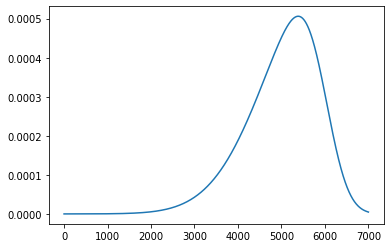

In [19]:
x = np.linspace(0,7000,10000)[1:-1]
dist = ss.skewnorm(loc=6000,scale=1300,a=-3)
plt.plot(x, dist.pdf(x))

Due to our desired posterior, we will use weakly informative priors that create $\mu$, $\sigma$ and $\alpha$ values around this distribution.

### Separate model

For the separate model, we have decided to go with

$$\mu \sim Norm(6000,10000)$$
$$\sigma \sim Cauchy(1000,10000)$$
$$\alpha \sim Norm(0,10000)$$

The posterior draws from these priors will be focused around the desired posterior but still with the large variance, our priors will be weakly informative.

### Hierarchical model

For the hierarchical model, we will first simulate the $\tau$ values that generate $\mu$ and $\sigma$ values. When we simulate values for $\mu$ and $\sigma$ around the desired distribution values with a great variance, we can possibly tackle part of the error we would create by choosing informative priors. For the $\tau$ we have gone with priors:

$$\tau \sim Norm(\mu_0,\sigma_0), where$$

$$\mu_0 \sim Norm(\mu_{\mu0},\mu_{\sigma0})$$
$$\mu_{\mu0} \sim Norm(6000,10000)$$
$$\mu_{\sigma0} \sim Cauchy(1000,10000), and$$

$$\sigma_0 \sim Cauchy(\sigma_{\mu0},\sigma_{\sigma0}), where$$
$$\sigma_{\mu0} \sim Norm(1000,10000)$$
$$\sigma_{\sigma0} \sim Cauchy(1000,10000)$$

This way we will generate $\tau$ values by taking different means and deviations from the different distributions. For $\alpha$ we have used the same distribution as in the separate model:

$$\alpha \sim Norm(0,10000)$$

## The model and training

Next off we are going to introduce our model and train it using STAN.

This model is a modified version of "Comparison of k groups with common variance (ANOVA)" accessed on 06/12/19 from http://avehtari.github.io/BDA_R_demos/demos_rstan/rstan_demo.html#8_comparison_of_k_groups_with_hierarchical_models

### Separate model

In [20]:
separate_model = """

data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1, upper=K> x[N]; // groups indicator
    vector[N] y; // data
    int mu_mu;
    int mu_sigma;
    int sigma_mu;
    int sigma_sigma;
    int alpha_mu;
    int alpha_sigma;
    
}

parameters {
    vector<lower=0>[K] mu;
    vector<lower=0>[K] sigma;
    real alpha;
}

model {
    mu ~ normal(mu_mu, mu_sigma);
    sigma ~ cauchy(sigma_mu, sigma_sigma);
    alpha ~ normal(alpha_mu, alpha_sigma);
    y ~ skew_normal(mu[x], sigma[x], alpha);
}
generated quantities {
    vector[K] ypred;
    vector[N] log_lik;
    for (k in 1:K)
        ypred[k] = skew_normal_rng(mu[k], sigma[k], alpha);
    for (n in 1:N)
        log_lik[n] = skew_normal_lpdf(y[n] | mu[x[n]], sigma[x[n]], alpha);
}

"""

In [21]:
separate_stan = pystan.StanModel(model_code=separate_model)

traffic_data = traffic_by_month

K = len(traffic_data)
y = [datapoint for month in traffic_data for datapoint in month]
x = [i+1 for i in range(K) for j in range(len(traffic_data[0]))]
N = len(x)
mu_mu = 6000
mu_sigma = 10000
sigma_mu = 1000
sigma_sigma = 10000
alpha_mu = 0
alpha_sigma = 10000

separate_data = {
    'N': N,
    'K': K,
    'y': y,
    'x': x,
    'mu_mu': mu_mu,
    'mu_sigma': mu_sigma,
    'sigma_mu': sigma_mu,
    'sigma_sigma': sigma_sigma,
    'alpha_mu': alpha_mu,
    'alpha_sigma': alpha_sigma
}

separate_fit = separate_stan.sampling(data=separate_data)

separate_samples = separate_fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e8b9b0d3c6e45f7b8f4569ed26330c0c NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


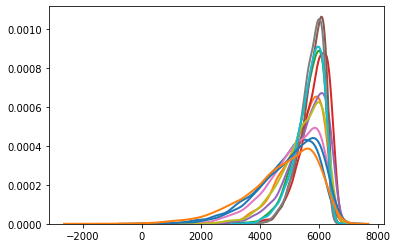

In [22]:
[sns.distplot(separate_samples['ypred'][:,i],hist=False,bins=30,kde_kws={'linewidth': 2}) for i in range(12)];

### Hierarchical model

In [23]:
hierarchical_model = """
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1, upper=K> x[N]; // groups indicator
    vector[N] y; // data
    
    int mumu0_mu;
    int mumu0_sigma;
    int musigma0_mu;
    int musigma0_sigma;
    
    int sigmamu0_mu;
    int sigmamu0_sigma;
    int sigmasigma0_mu;
    int sigmasigma0_sigma;
    
    int alpha_mu;
    int alpha_sigma;
}

parameters {    
    real mumu0;
    real<lower=0> musigma0;
    vector<lower=0>[K] mu;
    real sigmamu0;
    real<lower=0> sigmasigma0;
    vector<lower=0>[K] sigma;
    real alpha;
}
model {
    mumu0 ~ normal(mumu0_mu, mumu0_sigma);
    musigma0 ~ cauchy(musigma0_mu, musigma0_sigma);
    mu ~ normal(mumu0, musigma0);
    
    sigmamu0 ~ normal(sigmamu0_mu, sigmamu0_sigma);
    sigmasigma0 ~ cauchy(sigmasigma0_mu, sigmasigma0_sigma);
    sigma ~ cauchy(sigmamu0, sigmasigma0);
    
    alpha ~ normal(alpha_mu, alpha_sigma);
    
    y ~ skew_normal(mu[x], sigma[x], alpha);
}

generated quantities {
    vector[K] ypred;
    vector[N] log_lik;
    for (k in 1:K)
        ypred[k] = skew_normal_rng(mu[k], sigma[k], alpha);
    for (n in 1:N)
        log_lik[n] = skew_normal_lpdf(y[n] | mu[x[n]], sigma[x[n]], alpha);
}

"""

In [24]:
hierarchical_stan = pystan.StanModel(model_code=hierarchical_model)

traffic_data = traffic_by_month

K = len(traffic_data)
y = [datapoint for month in traffic_data for datapoint in month]
x = [i+1 for i in range(K) for j in range(len(traffic_data[0]))]
N = len(x)

mumu0_mu = 6000
mumu0_sigma = 10000
musigma0_mu = 1000
musigma0_sigma = 10000
sigmamu0_mu = 1000
sigmamu0_sigma = 10000
sigmasigma0_mu = 1000
sigmasigma0_sigma = 10000
alpha_mu = 0
alpha_sigma = 10000

hierarchical_data = {
    'N': N,
    'K': K,
    'y': y,
    'x': x,
    'mumu0_mu': mumu0_mu,
    'mumu0_sigma': mumu0_sigma,
    'musigma0_mu': musigma0_mu,
    'musigma0_sigma': musigma0_sigma,
    'sigmamu0_mu': sigmamu0_mu,
    'sigmamu0_sigma': sigmamu0_sigma,
    'sigmasigma0_mu': sigmasigma0_mu,
    'sigmasigma0_sigma': sigmasigma0_sigma,
    'alpha_mu': alpha_mu,
    'alpha_sigma': alpha_sigma
}

hierarchical_fit = hierarchical_stan.sampling(data=hierarchical_data)

hierarchical_samples = hierarchical_fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f94804c6e392d0ee88e4cdd87b692cc7 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


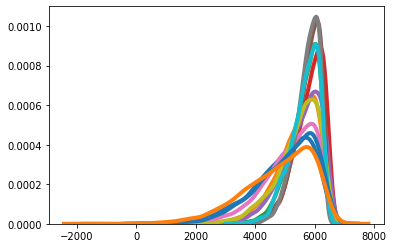

In [25]:
[sns.distplot(hierarchical_samples['ypred'][:,i], hist=False, kde=True, 
             bins=int(180/5),
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}) for i in range(12)];

## Convergence diagnostics

We are using pystan's inbuilt `check_hmc_diagnostics` to ensure that the models have converged. This means, for example, ensuring that for all the $\hat{R}$ values for the models it holds that $\hat{R} < 1.05$. The diagnostics check will run all the necessary tests, such as efficient sampling amount, $\hat{R}$ values, non-divergence, etc. Since all the checks are true, we can conclude that both models have converged succesfully.

In [26]:
print("separate model:")
print(pystan.check_hmc_diagnostics(separate_fit))
print("hierarchical model:")
print(pystan.check_hmc_diagnostics(hierarchical_fit))

separate model:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}
hierarchical model:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


## Posterior predictive checking

Our posterior predictive checking will consist of comparing the differences of mean values between the models and actual data. Furthermore, we will conduct qualitative assessment. We will plot the results next to the data and compare visually.

Below are the means for each month and average of the means are computed for both models:

In [28]:
hierarchical_mean_diffs = []
separate_mean_diffs = []

for i in range(12):
    traffic_mean = np.mean(traffic_by_month[i])
    hierarchical_mean = np.mean(hierarchical_samples['ypred'][:,i])
    separate_mean = np.mean(separate_samples['ypred'][:,i])
    
    hierarchical_mean_diff = abs(hierarchical_mean - traffic_mean)
    separate_mean_diff = abs(separate_mean - traffic_mean)
    
    hierarchical_mean_diffs.append(hierarchical_mean_diff)
    separate_mean_diffs.append(separate_mean_diff)
    
    print("month {}/12 traffic means:".format(i+1))
    print("traffic data: {}".format(round(traffic_mean, 2)))
    print("hierarchical model: {}, diff: {}"
          .format(round(hierarchical_mean, 2), round(hierarchical_mean_diff, 2)))
    print("separate model: {}, diff: {}\n"
          .format(round(separate_mean, 2), round(separate_mean_diff, 2)))

average_diff_hierarchical = np.mean(hierarchical_mean_diffs)
average_diff_separate = np.mean(separate_mean_diffs)

print("\nAverage diff for hierarchical model: {}".format(round(average_diff_hierarchical, 2)))
print("\nAverage diff for separate model: {}".format(round(average_diff_separate, 2)))

month 1/12 traffic means:
traffic data: 5077.49
hierarchical model: 4938.28, diff: 139.2
separate model: 4894.84, diff: 182.64

month 2/12 traffic means:
traffic data: 5484.21
hierarchical model: 5433.33, diff: 50.88
separate model: 5433.06, diff: 51.15

month 3/12 traffic means:
traffic data: 5718.26
hierarchical model: 5663.83, diff: 54.43
separate model: 5651.17, diff: 67.09

month 4/12 traffic means:
traffic data: 5907.89
hierarchical model: 5827.1, diff: 80.79
separate model: 5860.02, diff: 47.87

month 5/12 traffic means:
traffic data: 5798.97
hierarchical model: 5581.92, diff: 217.05
separate model: 5618.76, diff: 180.21

month 6/12 traffic means:
traffic data: 5768.49
hierarchical model: 5773.1, diff: 4.61
separate model: 5781.55, diff: 13.06

month 7/12 traffic means:
traffic data: 5248.3
hierarchical model: 5189.41, diff: 58.89
separate model: 5175.87, diff: 72.43

month 8/12 traffic means:
traffic data: 5729.59
hierarchical model: 5742.52, diff: 12.93
separate model: 5732.92

Based on this calculation, the difference between the means for each month is small for both models. For the hierarchical model, the mean is slightly smaller.

Next off, we will plott the predictions for each month:

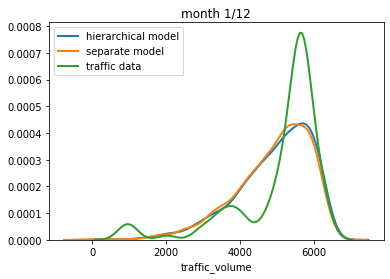

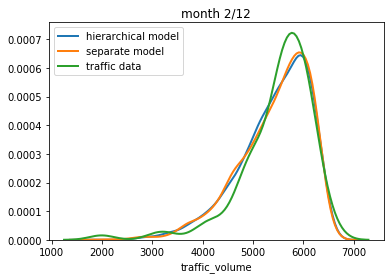

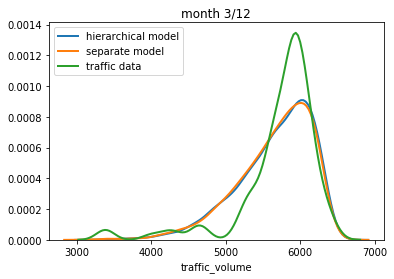

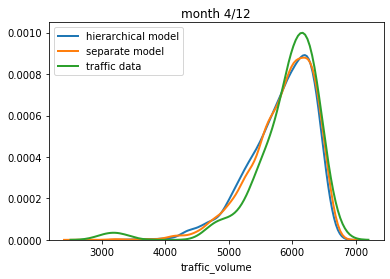

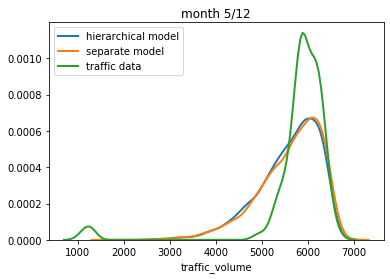

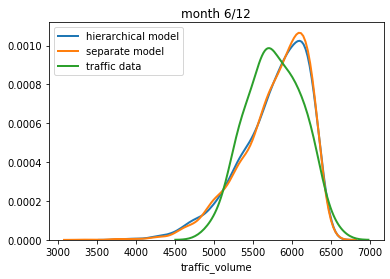

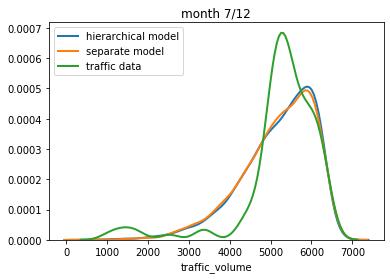

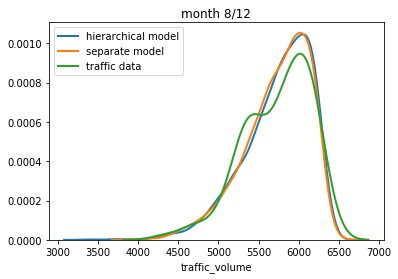

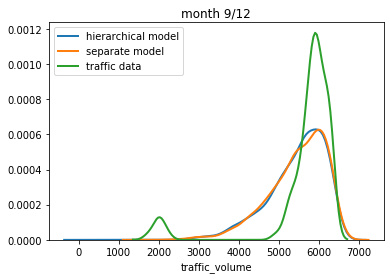

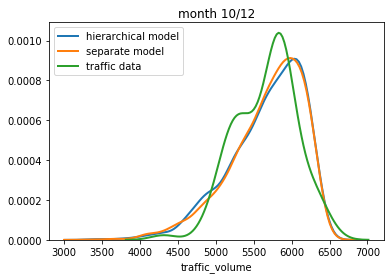

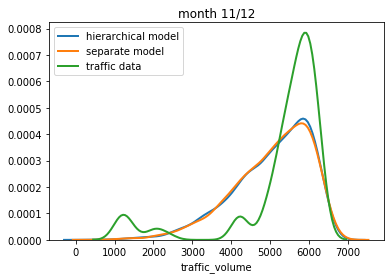

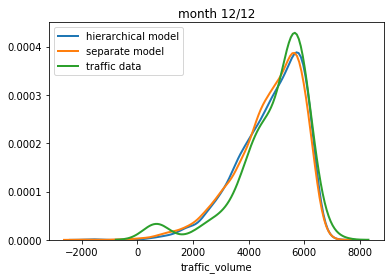

In [29]:
for i in range(12):
    sns.distplot(hierarchical_samples['ypred'][:,i], hist=False,bins=30, kde_kws={'linewidth': 2},
                label='hierarchical model')
    sns.distplot(separate_samples['ypred'][:,i], hist=False,bins=30, kde_kws={'linewidth': 2},
                label='separate model')
    sns.distplot(traffic_by_month[i], hist=False, bins=30,kde_kws={'linewidth': 2},
                label='traffic data')
    plt.title("month {}/12".format(i+1))
    plt.show()

Clearly both of the models resemble the actual data. Both models are slightly skewed, which matches the real data. However, the graph based on the real data has a bumpy tail, which is not simulated by the models. Furthermore, for some months with big bumps, the predictions compensate these bumps with a larger standard deviation and lower peak.

## Model comparison

It seems like both of our models include a couple of bad k-diagnostics values and the results resemble each other a lot based on the plots above. The PSIS-LOO values are close to each other, as well as SE. **Based on the PSIS-LOO values we should choose the hierarchical model, since it has a greater value.** Furthermore, the k-hat values are lower on the high k-hat points.

In [30]:
separate_inference_data = az.from_pystan(
    posterior=separate_fit,
    observed_data=['y'],
    log_likelihood='log_lik'
)

s = az.loo(separate_inference_data, pointwise=True, scale="log")
s

Computed from 4000 by 1212 log-likelihood matrix

         Estimate       SE
elpd_loo -9476.00    45.19
p_loo       45.41        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1206   99.5%
 (0.5, 0.7]   (ok)          6    0.5%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [31]:
hierarchical_inference_data = az.from_pystan(
    posterior=hierarchical_fit,
    observed_data=['y'],
    log_likelihood='log_lik'
)

h = az.loo(hierarchical_inference_data, pointwise=True, scale="log")
h

Computed from 4000 by 1212 log-likelihood matrix

         Estimate       SE
elpd_loo -9474.68    45.78
p_loo       43.23        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1207   99.6%
 (0.5, 0.7]   (ok)          5    0.4%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

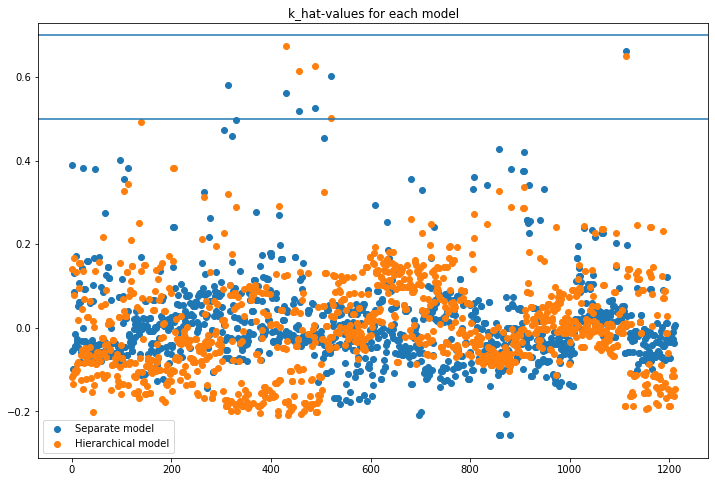

In [32]:
plt.figure(figsize=(12,8))
plt.scatter(range(1212), s.pareto_k.data, label="Separate model")
plt.scatter(range(1212), h.pareto_k.data, label="Hierarchical model")
plt.axhline(y=0.5)
plt.axhline(y=0.7)
plt.title("k_hat-values for each model")
_ =plt.legend()

In [33]:
s.p_loo

45.40986962133138

In [34]:
h.p_loo

43.23242638874581

In [35]:
s.loo

-9475.999446831902

In [36]:
h.loo

-9474.678585998234

## Sensitivity analysis

As our sensitivity analysis, we will try two different prior choices for the separate model and see how it effects the posterior distribution.

Using more specific prior for the separate model:

In [37]:
mu_mu = 5700
mu_sigma = 10
sigma_mu = 800
sigma_sigma = 10
alpha_mu = -5
alpha_sigma = 10

separate_data = {
    'N': N,
    'K': K,
    'y': y,
    'x': x,
    'mu_mu': mu_mu,
    'mu_sigma': mu_sigma,
    'sigma_mu': sigma_mu,
    'sigma_sigma': sigma_sigma,
    'alpha_mu': alpha_mu,
    'alpha_sigma': alpha_sigma
}

separate_fit = separate_stan.sampling(data=separate_data)

separate_samples = separate_fit.extract(permuted=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [38]:
separate_inference_data = az.from_pystan(
    posterior=separate_fit,
    observed_data=['y'],
    log_likelihood='log_lik'
)

s = az.loo(separate_inference_data, pointwise=True, scale="log")
s

C:\Users\henri\Anaconda3\lib\site-packages\arviz\stats\stats.py:682: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\henri\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\henri\Anaconda3\lib\site-packages\arviz\stats\stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 1212 log-likelihood matrix

         Estimate       SE
elpd_loo -11358.48    45.80
p_loo      624.27        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1104   91.1%
 (0.5, 0.7]   (ok)          8    0.7%
   (0.7, 1]   (bad)        11    0.9%
   (1, Inf)   (very bad)   89    7.3%

Using extremely vague prior for the separate model:

In [39]:
mu_mu = 0
mu_sigma = 1000000
sigma_mu = 0
sigma_sigma = 1000000
alpha_mu = 0
alpha_sigma = 1000000

separate_data = {
    'N': N,
    'K': K,
    'y': y,
    'x': x,
    'mu_mu': mu_mu,
    'mu_sigma': mu_sigma,
    'sigma_mu': sigma_mu,
    'sigma_sigma': sigma_sigma,
    'alpha_mu': alpha_mu,
    'alpha_sigma': alpha_sigma
}

separate_fit = separate_stan.sampling(data=separate_data)

separate_samples = separate_fit.extract(permuted=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [40]:
separate_inference_data = az.from_pystan(
    posterior=separate_fit,
    observed_data=['y'],
    log_likelihood='log_lik'
)

s = az.loo(separate_inference_data, pointwise=True, scale="log")
s

C:\Users\henri\Anaconda3\lib\site-packages\arviz\stats\stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 1212 log-likelihood matrix

         Estimate       SE
elpd_loo -9477.56    45.52
p_loo       47.25        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1207   99.6%
 (0.5, 0.7]   (ok)          1    0.1%
   (0.7, 1]   (bad)         4    0.3%
   (1, Inf)   (very bad)    0    0.0%

Clearly using a very specific informative prior for the separate model leads to overfitting. However, extremely vague prior actually yielded quite good results, which might mean that the model could have used a less informative/noninformative prior.

We have not run the sensitivity analysis separately for our hierarchical model. This is due to the fact that running and testing the priors during the project, we have come to the same conclusion as with the separate model sensitivity analysis.

Overall, the result of this analysis is that the prior chosen for the separate model is on the edge of being too specific, and the results are dependant on the prior values. Clearly, the priors should not be more informative, and possibly could be a bit weaker. Still, the best results are with our current priors and we will continue with those at the moment.

## Discussion

After all, the models can predict traffic volumes based on the month. Some variation in the monthly tails cause issues for forecasting. There were a lot of problems when implementing the $\alpha$ into skewed normal distribution and we were not able to get the monthly $\alpha$ vector to work. In case we were able to fix the $\alpha$ vector into the model, the tails of the predictions could improve.

Our current models are really close to each other and it creates the question whether the models should be more robust and include more data to create more diverse results. A point of improvement would be to create more diverse models. Currently, the predictions our models create seem really similar and the results are close to each other.

Our prior choices for the models are mostly logical for the separate model, but for the hierarchical model, the priors could be explored more. Given more time, this could be done and the prior choices could be improved. Furthermore, there are k-hat values over 0.7 every once in a while and this would represent some overfitting. This would suggest to use weaker priors. Our sensitivity analysis supports this conclusion, by ending up with bad results using a more informative prior, and then better results using weaker priors. 

In the future, one of the things we would work on further, is to include the weather and holidays data into the model. These could possibly explain some of the skewness in, for example, summer times and Christmas when there are holidays. Furthermore, when it is rainy, people will most likely use more public transport instead of walking or cycling to work.

Another aspect to think in the future is that currently we are separately predicting 12 different months. For the efficiency of the computation, it could be beneficial to predict only a few problematic months, or months where there would be a lot of maintenance work to be done and the efficiency is the most important aspect. Depending on what the operators want, the public transportation volumes could be used just for those specific needs, whatever the month they want to predict.